# IMPORT DEPENDENCIES

In [7]:
import pandas as pd
import numpy as np
import math
import random
import operator
import matplotlib.pyplot as plt
import tensorflow as tf

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
from tensorflow.keras.utils import to_categorical

In [10]:
import warnings
#suppress warnings
warnings.filterwarnings('ignore')

# EXPLORATORY DATA ANALYSIS

## Read Dataset

In [11]:
df = pd.read_csv("glass.csv")

In [12]:
df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


In [13]:
df.isna().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [14]:
X = df.drop(columns=["Type"], axis=1).copy()
y = to_categorical(df["Type"].copy())

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# NEURAL NETWORK

In [16]:
'''
Initialize Metric Class
'''
class Metric:
    def rmse(self, prediction, target):
        return np.sqrt(np.square(prediction - target).mean())
        
    def accuracy(self, prediction, target):
        return np.equal(prediction, target).sum()/len(prediction)
    
metric = Metric()

In [17]:
class NeuralNetwork:
    def __init__(self):
        self.layers = list()
        self.dimensions = list()
        self.weights = list()
        
    def init(self):
        layers = []
        for j in range(len(self.dimensions)-1):
            shape = (self.dimensions[j],self.dimensions[j+1])
            layer = np.random.normal(size=shape)
            layers.append(layer)    
        self.weights.append(np.array(layers, dtype=object))
        
    '''
    MENAMBAHKAN INPUT LAYER
    '''
    def addInputLayer(self, shape, activation="linear"):
        self.layers.append({ "units": shape, "activation":activation, "layer":"input" })
        self.dimensions.append(shape)

    '''
    MENAMBAHKAN LAYER
    Penambahan layer paling akhir merupakan output layer
    '''
    def addLayer(self, units, activation="linear"):
        layer = { "units": units, "activation": activation, "layer":"output"}
        self.layers[len(self.layers)-1]["layer"] = "hidden"
        self.layers.append(layer)
        self.dimensions.append(units)
            
    '''
    Mengaktivasi output menggunakan fungsi aktivasi
    '''
    def activate(self, activation):
        activation_func = {
            "sigmoid" : lambda x: 1/(1+np.exp(-x)),
            "relu" : lambda x: max(0,x),
            "tanh" : lambda x: np.tanh(x),
            "linear" : lambda x: x
        }
        return activation_func[activation]

    '''
    Menghitung output dengan feedforward propagation
    '''
    def feedforward(self, inputs, weights):
        inputs = inputs
        for L in range(len(self.dimensions)-1):
            output = np.matmul(inputs, weights[L])
            actv_output = np.array(list(map(self.activate(self.layers[L]["activation"]), output)))
            inputs = actv_output
        return inputs
    
    '''
    Fungsi menghitung fitness individu
    '''
    def fitness_func(self,weights):

        pred_list = []
        for train in self.features:
            pred = self.feedforward(train, weights)
            pred_list.append(pred)

            prediction = np.argmax(pred_list, axis=1)
            output = np.argmax(self.output, axis=1)
            
        loss = metric.rmse(prediction, output) # RMSE
        accuracy = metric.accuracy(prediction, output)
            
        return loss, accuracy
    
    def predict(self, X):
        res = list()
        for i in X:
            res.append(self.feedforward(i, self.weights))
        return np.array(res)
        
    def gradient_descent(self):
        pass
    
    def fit(self, X, y, epochs, lr):
        self.features = X
        self.output = y
        self.lr = lr
        
        for i in range(epochs):
            loss, accuracy = self.fitness_func(self.X, self.weights)
            
            break


In [18]:
class EvolvingNN(NeuralNetwork):
  def __init__(self):
    super().__init__()

  '''
  Membuat populasi awal sesuai dengan jumlah yang ditentukan
  '''
  def init(self,num_population):
    self.population = []
    for i in range(num_population):
      layers = []
      for j in range(len(self.dimensions)-1):
        shape = (self.dimensions[j],self.dimensions[j+1])
        layer = np.random.normal(size=shape)
        layers.append(layer)
      self.population.append(np.array(layers, dtype=object))
  
  '''
  Menghitung fitness untuk populasi
  Diurutkan, kemudian diambil sebesar elite_percentage
  '''
  def fitness_population(self,elite_percentage):
    new_pop = []
    for id_ind in range(len(self.population)):
      loss, accuracy = super().fitness_func(self.population[id_ind]) 
      new_pop.append((loss,accuracy,self.population[id_ind]))
    
    # selection ambil sesuai elite_percentage
    # sorting dengan loss terendah dan acc tertinggi
    new_pop.sort(key=operator.itemgetter(0),reverse=False)
    # ambil top elite_percentage
    select_count = math.floor(len(self.population)*elite_percentage)
    self.population = [x[2] for x in new_pop][:select_count]

  '''
  Memilih berapa banyak terjadi crossover
  Kemudian lakukan generate 1 child untuk tiap crossover
  '''
  def crossover(self,crossover_percentage):
    # jumlah pernikahan
    number_of_crossover = math.floor(crossover_percentage*len(self.population))
    list_parent = random.sample(range(0,len(self.population)),2*number_of_crossover)

    for i in range(number_of_crossover):
      p1 = self.population[list_parent[i]]
      p2 = self.population[list_parent[i+1]]
      m = random.random()
      
      # blend crossover
      c = (1-m) * p1 + m * p2
      self.population.append(c)

  '''
  Mutasi yang digunakan gaussian noise
  '''
  def mutation(self,mutation_percentage):
    number_of_mutation = math.floor(mutation_percentage*len(self.population))

    for i in range(number_of_mutation):
      # ambil individu
      idmutate = random.randint(0,len(self.population)-1)
      self.population[idmutate] = self.population[idmutate] * np.random.normal(1,1)
      

  '''
  Fitting model Neural Network dengan Genetic Algorithm
  '''
  def fit(self, X, y, n_pop, n_gen):
    self.features = X
    self.output = y
    
    self.init(n_pop)
    number_of_iteration = n_gen
    losses = []
    accuracies = []
    for i in range(number_of_iteration):
      self.fitness_population(0.8)
      
      best_pop = self.population[0]
      loss, accuracy = super().fitness_func(best_pop)
      losses.append(loss)
      accuracies.append(accuracy)
      
      print("Generasi ke",i+1,"- Jumlah populasi",len(self.population),"- RMSE:",loss,"- Acc:",accuracy)

      self.crossover(0.5)
      self.mutation(0.5)
      
      self.weights = self.population[0]
      
      if i == number_of_iteration - 1:
        return losses, accuracies

    '''Gradient Descent'''
    def mean_squared_error(y_true, y_predicted):
	
      # Calculating the loss or cost
      cost = np.sum((y_true-y_predicted)**2) / len(y_true)
      return cost

    # Gradient Descent Function
    # Here iterations, learning_rate, stopping_threshold
    # are hyperparameters that can be tuned
    def gradient_descent(x, y, iterations = 1000, learning_rate = 0.0001,
              stopping_threshold = 1e-6):
      
      # Initializing weight, bias, learning rate and iterations
      current_weight = 0.1
      current_bias = 0.01
      iterations = iterations
      learning_rate = learning_rate
      n = float(len(x))
      
      costs = []
      weights = []
      previous_cost = None
      
      # Estimation of optimal parameters
      for i in range(iterations):
        
        # Making predictions
        y_predicted = (current_weight * x) + current_bias
        
        # Calculating the current cost
        current_cost = mean_squared_error(y, y_predicted)

        # If the change in cost is less than or equal to
        # stopping_threshold we stop the gradient descent
        if previous_cost and abs(previous_cost-current_cost)<=stopping_threshold:
          break
        
        previous_cost = current_cost

        costs.append(current_cost)
        weights.append(current_weight)
        
        # Calculating the gradients
        weight_derivative = -(2/n) * sum(x * (y-y_predicted))
        bias_derivative = -(2/n) * sum(y-y_predicted)
        
        # Updating weights and bias
        current_weight = current_weight - (learning_rate * weight_derivative)
        current_bias = current_bias - (learning_rate * bias_derivative)
            
        # Printing the parameters for each 1000th iteration
        print(f"Iteration {i+1}: Cost {current_cost}, Weight \
        {current_weight}, Bias {current_bias}")
      
      
      # Visualizing the weights and cost at for all iterations
      plt.figure(figsize = (8,6))
      plt.plot(weights, costs)
      plt.scatter(weights, costs, marker='o', color='red')
      plt.title("Cost vs Weights")
      plt.ylabel("Cost")
      plt.xlabel("Weight")
      plt.show()
      
      return current_weight, current_bias


    def main():
      
      # Data
      X = np.array([32.50234527, 53.42680403, 61.53035803, 47.47563963, 59.81320787,
        55.14218841, 52.21179669, 39.29956669, 48.10504169, 52.55001444,
        45.41973014, 54.35163488, 44.1640495 , 58.16847072, 56.72720806,
        48.95588857, 44.68719623, 60.29732685, 45.61864377, 38.81681754])
      Y = np.array([31.70700585, 68.77759598, 62.5623823 , 71.54663223, 87.23092513,
        78.21151827, 79.64197305, 59.17148932, 75.3312423 , 71.30087989,
        55.16567715, 82.47884676, 62.00892325, 75.39287043, 81.43619216,
        60.72360244, 82.89250373, 97.37989686, 48.84715332, 56.87721319])

      # Estimating weight and bias using gradient descent
      estimated_weight, estimated_bias = gradient_descent(X, Y, iterations=2000)
      print(f"Estimated Weight: {estimated_weight}\nEstimated Bias: {estimated_bias}")

      # Making predictions using estimated parameters
      Y_pred = estimated_weight*X + estimated_bias

      # Plotting the regression line
      plt.figure(figsize = (8,6))
      plt.scatter(X, Y, marker='o', color='red')
      plt.plot([min(X), max(X)], [min(Y_pred), max(Y_pred)], color='blue',markerfacecolor='red',
          markersize=10,linestyle='dashed')
      plt.xlabel("X")
      plt.ylabel("Y")
      plt.show()
          
        

In [19]:
evolvingNN = EvolvingNN()
evolvingNN.addInputLayer(X.shape[1], activation="sigmoid")
evolvingNN.addLayer(10, activation="sigmoid")
evolvingNN.addLayer(y.shape[1], activation="relu")

n_pop = 50
n_gen = 2
loss, accuracy = evolvingNN.fit(X_train.values, y_train, n_pop, n_gen)

Generasi ke 1 - Jumlah populasi 40 - RMSE: 2.0576486893187016 - Acc: 0.08187134502923976
Generasi ke 2 - Jumlah populasi 48 - RMSE: 2.0576486893187016 - Acc: 0.08187134502923976


In [20]:
y_pred = evolvingNN.predict(X_test.values)

In [21]:
y_test_1 = np.argmax(y_test, axis=1)
y_pred_1 = np.argmax(y_pred, axis=1)

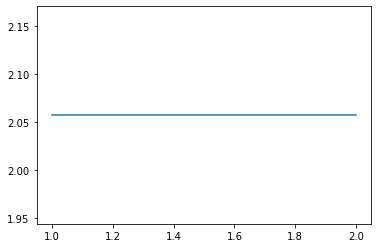

In [22]:
plt.plot(range(1,len(loss)+1),loss)

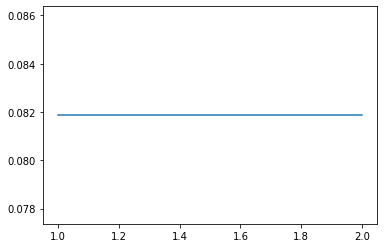

In [23]:
plt.plot(range(1,len(accuracy)+1), accuracy)

## NEURAL NETWORK GRADIENT DESCENT

In [23]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt

def mean_squared_error(y_true, y_predicted):
	
	# Calculating the loss or cost
	cost = np.sum((y_true-y_predicted)**2) / len(y_true)
	return cost

# Gradient Descent Function
# Here iterations, learning_rate, stopping_threshold
# are hyperparameters that can be tuned
def gradient_descent(x, y, iterations = 1000, learning_rate = 0.0001,
					stopping_threshold = 1e-6):
	
	# Initializing weight, bias, learning rate and iterations
	current_weight = 0.1
	current_bias = 0.01
	iterations = iterations
	learning_rate = learning_rate
	n = float(len(x))
	
	costs = []
	weights = []
	previous_cost = None
	
	# Estimation of optimal parameters
	for i in range(iterations):
		
		# Making predictions
		y_predicted = (current_weight * x) + current_bias
		
		# Calculating the current cost
		current_cost = mean_squared_error(y, y_predicted)

		# If the change in cost is less than or equal to
		# stopping_threshold we stop the gradient descent
		if previous_cost and abs(previous_cost-current_cost)<=stopping_threshold:
			break
		
		previous_cost = current_cost

		costs.append(current_cost)
		weights.append(current_weight)
		
		# Calculating the gradients
		weight_derivative = -(2/n) * sum(x * (y-y_predicted))
		bias_derivative = -(2/n) * sum(y-y_predicted)
		
		# Updating weights and bias
		current_weight = current_weight - (learning_rate * weight_derivative)
		current_bias = current_bias - (learning_rate * bias_derivative)
				
		# Printing the parameters for each 1000th iteration
		print(f"Iteration {i+1}: Cost {current_cost}, Weight \
		{current_weight}, Bias {current_bias}")
	
	
	# Visualizing the weights and cost at for all iterations
	plt.figure(figsize = (8,6))
	plt.plot(weights, costs)
	plt.scatter(weights, costs, marker='o', color='red')
	plt.title("Cost vs Weights")
	plt.ylabel("Cost")
	plt.xlabel("Weight")
	plt.show()
	
	return current_weight, current_bias


def main():
	
	# Data
	X = np.array([32.50234527, 53.42680403, 61.53035803, 47.47563963, 59.81320787,
		55.14218841, 52.21179669, 39.29956669, 48.10504169, 52.55001444,
		45.41973014, 54.35163488, 44.1640495 , 58.16847072, 56.72720806,
		48.95588857, 44.68719623, 60.29732685, 45.61864377, 38.81681754])
	Y = np.array([31.70700585, 68.77759598, 62.5623823 , 71.54663223, 87.23092513,
		78.21151827, 79.64197305, 59.17148932, 75.3312423 , 71.30087989,
		55.16567715, 82.47884676, 62.00892325, 75.39287043, 81.43619216,
		60.72360244, 82.89250373, 97.37989686, 48.84715332, 56.87721319])

	# Estimating weight and bias using gradient descent
	estimated_weight, estimated_bias = gradient_descent(X, Y, iterations=2000)
	print(f"Estimated Weight: {estimated_weight}\nEstimated Bias: {estimated_bias}")

	# Making predictions using estimated parameters
	Y_pred = estimated_weight*X + estimated_bias

	# Plotting the regression line
	plt.figure(figsize = (8,6))
	plt.scatter(X, Y, marker='o', color='red')
	plt.plot([min(X), max(X)], [min(Y_pred), max(Y_pred)], color='blue',markerfacecolor='red',
			markersize=10,linestyle='dashed')
	plt.xlabel("X")
	plt.ylabel("Y")
	plt.show()

	
if __name__=="__main__":
	main()
